In [208]:
import sys
from pathlib import Path

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [159]:
from config import *

In [160]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import my_io as io

# Import metadata information

In [161]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

,Pos,Grades,Stage,Directory
0,B1,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1,B3,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2,B5,2,II,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3,C6,AT,AT,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4,D7,3,IIIA,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7


In [163]:
datasets = df_metadata.Directory.to_list()
dataset_names = df_metadata.Pos.to_list()
dataset_grades = df_metadata.Grades.to_list()
dataset_stage = df_metadata.Stage.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

# Read all images 

In [170]:
all_imgs = []
all_pos = []
all_markers = []
all_grades = []
all_stages = []
for idx, dataset in enumerate(datasets[:-2]):
    pos = dataset_names[idx]
    grade = dataset_grades[idx]
    stage = dataset_stage[idx]
    imgs, markers = io.read_img(dataset, data_ROI)
    all_imgs.append(imgs)
    all_pos.append([pos]*len(markers))
    all_markers.append(markers)
    all_grades.append([grade]*len(markers))
    all_stages.append([stage]*len(markers))

In [171]:
all_pos = list(itertools.chain(*all_pos))
all_grades = list(itertools.chain(*all_grades))
all_stages = list(itertools.chain(*all_stages))
all_markers = list(itertools.chain(*all_markers))
all_imgs = np.concatenate(all_imgs, axis=0)

In [172]:
dict_pos = {}
dict_grade = {}
dict_stage = {}
all_pos_set = set(all_pos)
all_grade_set = set(all_grades)
all_stage_set = set(all_stages)

n = 0
for pos in all_pos_set:
    dict_pos[pos] = n
    n += 1
n = 0
for pos in all_grade_set:
    dict_grade[pos] = n
    n += 1
n = 0
for pos in all_stage_set:
    dict_stage[pos] = n
    n += 1
    
all_pos_int = [dict_pos[name] for name in all_pos]
all_pos_label = [pos for pos in all_pos_set]

all_grade_int = [dict_grade[name] for name in all_grades]
all_grade_label = [pos for pos in all_grade_set]

all_stage_int = [dict_stage[name] for name in all_stages]
all_stage_label = [pos for pos in all_stage_set]

# Clustering

## PCA dimension reduction 

Text(0, 0.5, 'explained variance')

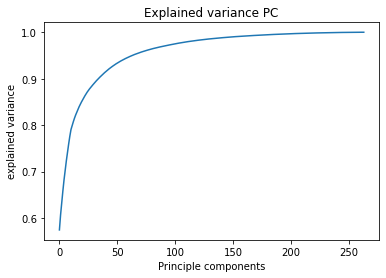

In [173]:
# Transform image to flat size for pca
imgs_flat = all_imgs.reshape((len(all_pos), -1))

# PCA transformation
pca = PCA()
pca.fit(imgs_flat)
X_pca = pca.transform(imgs_flat)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance PC")
plt.xlabel("Principle components")
plt.ylabel("explained variance")

## Umap 2D

In [174]:
embedding = umap.UMAP(random_state=2).fit_transform(X_pca[:, :200])
X, Y = embedding[:, 0], embedding[:, 1]

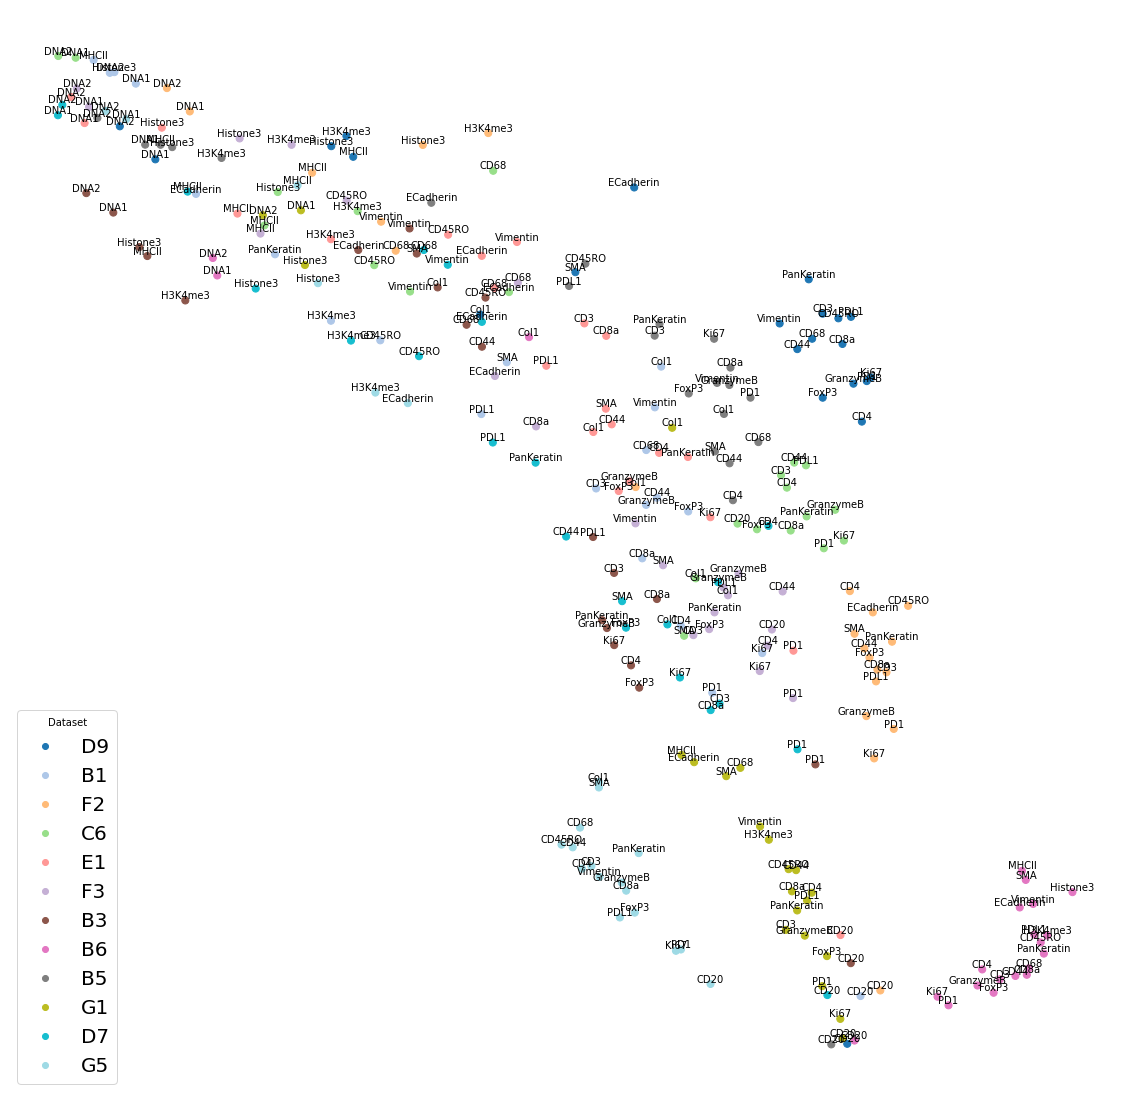

In [179]:
fig, ax = plt.subplots(figsize=(20, 20))
scatter = ax.scatter(X, Y, c=all_pos_int, cmap='tab20', s=50)
for i, name in enumerate(all_markers):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom')
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')
ax.axis('off')
ax.legend(handles=scatter.legend_elements()[0], 
          labels=all_pos_label, loc="lower left", title="Dataset", prop={'size': 20})

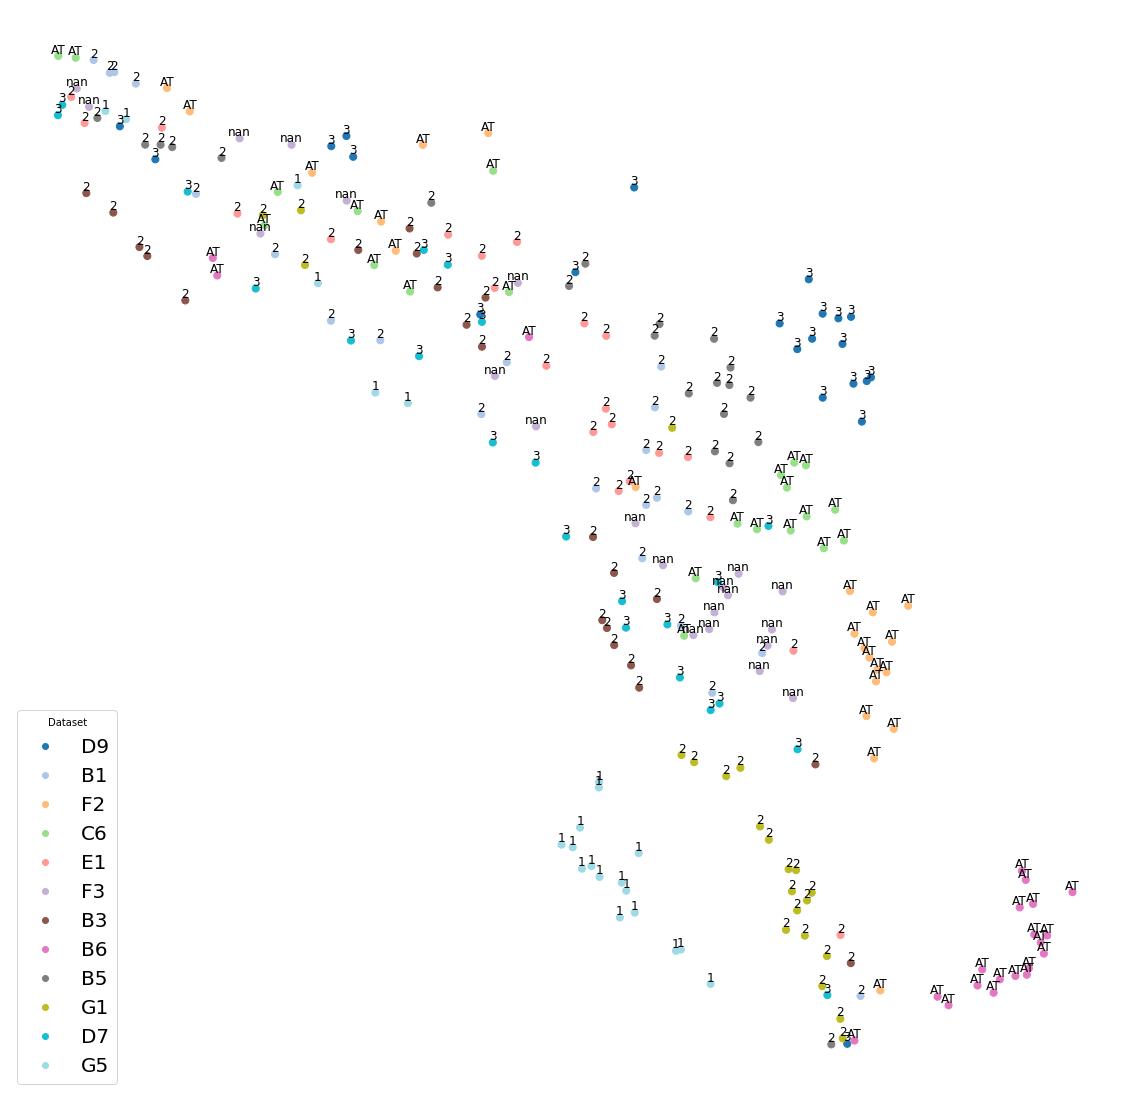

In [187]:
fig, ax = plt.subplots(figsize=(20, 20))
scatter = ax.scatter(X, Y, c=all_pos_int, cmap='tab20', s=50)
for i, name in enumerate(all_grades):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')
ax.axis('off')
ax.legend(handles=scatter.legend_elements()[0], 
          labels=all_pos_label, loc="lower left", title="Dataset", prop={'size': 20})

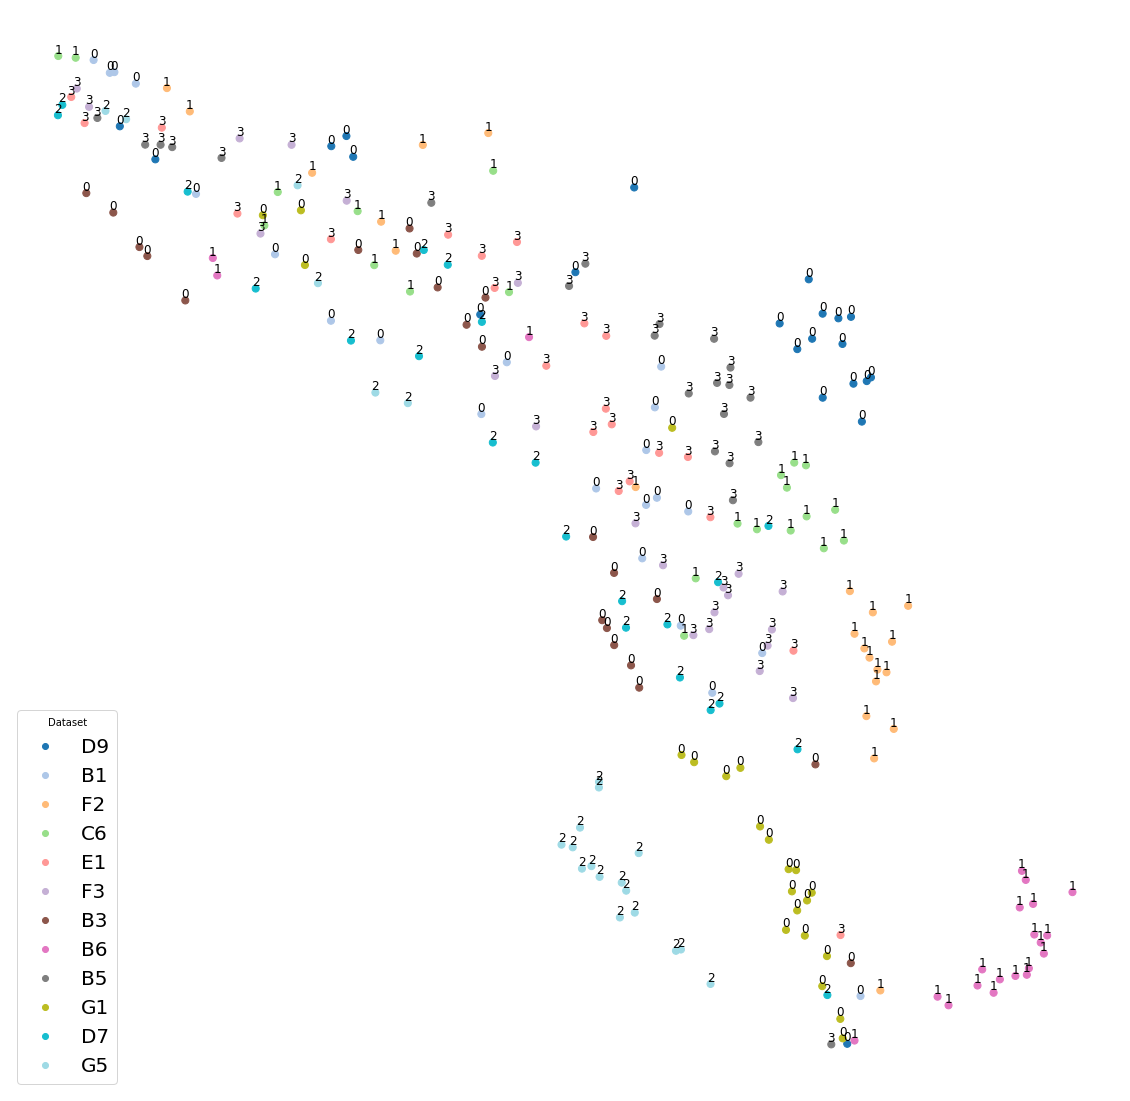

In [188]:
fig, ax = plt.subplots(figsize=(20, 20))
scatter = ax.scatter(X, Y, c=all_pos_int, cmap='tab20', s=50)
for i, name in enumerate(all_stage_int):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')
ax.axis('off')
ax.legend(handles=scatter.legend_elements()[0], 
          labels=all_pos_label, loc="lower left", title="Dataset", prop={'size': 20})

In [180]:
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
labels_2D = clustering.labels_

(12.547252702713013, 21.302617025375366, 5.647686457633972, 11.596844696998597)

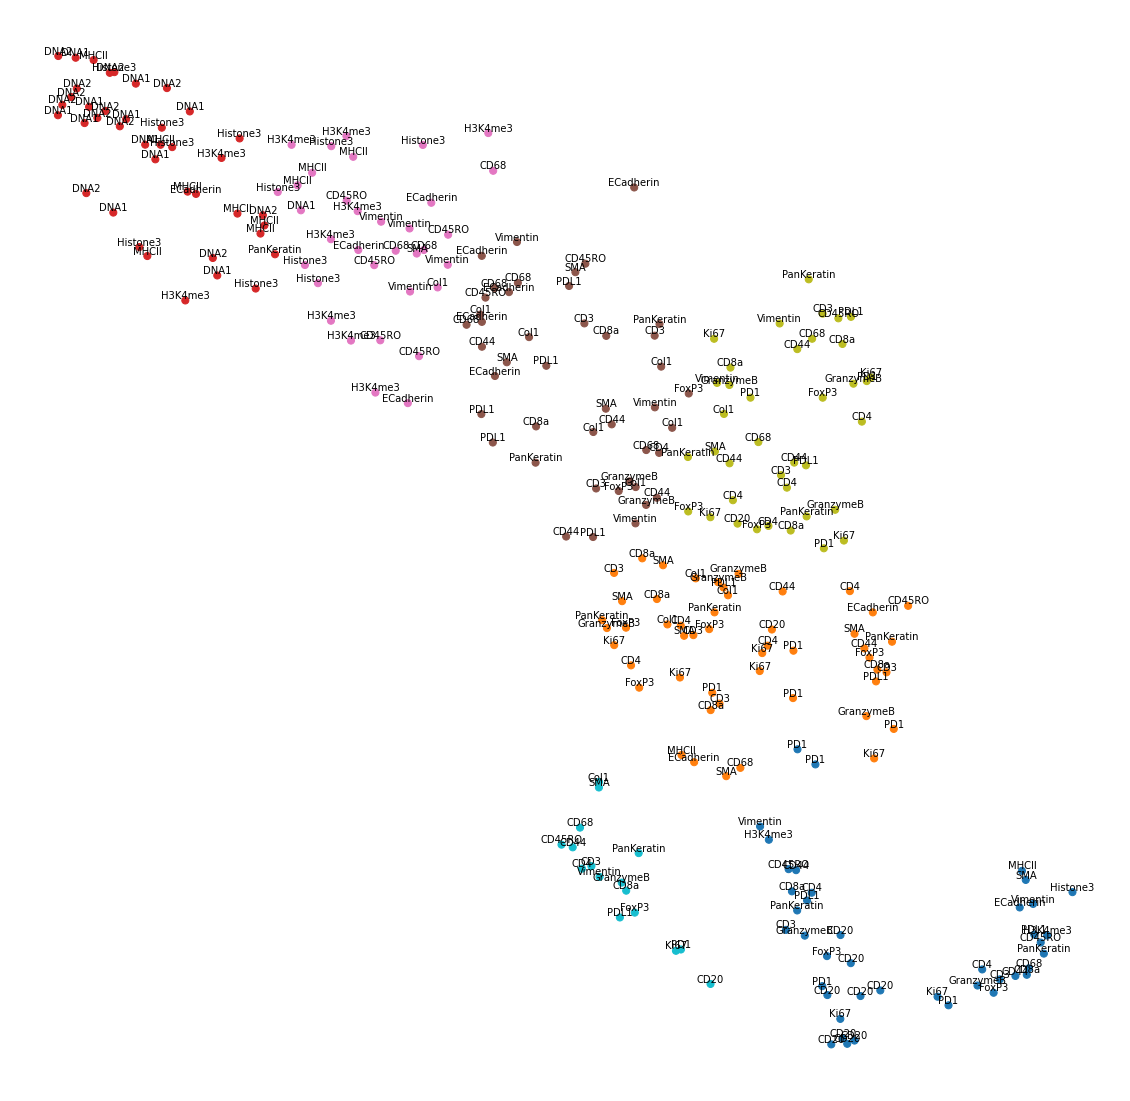

In [182]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(X, Y, c=labels_2D, s=50, cmap='tab10')
# Annotate scatter 
for i, name in enumerate(all_markers):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom')
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.axis('off')

(12.547252702713013, 21.302617025375366, 5.647686457633972, 11.596844696998597)

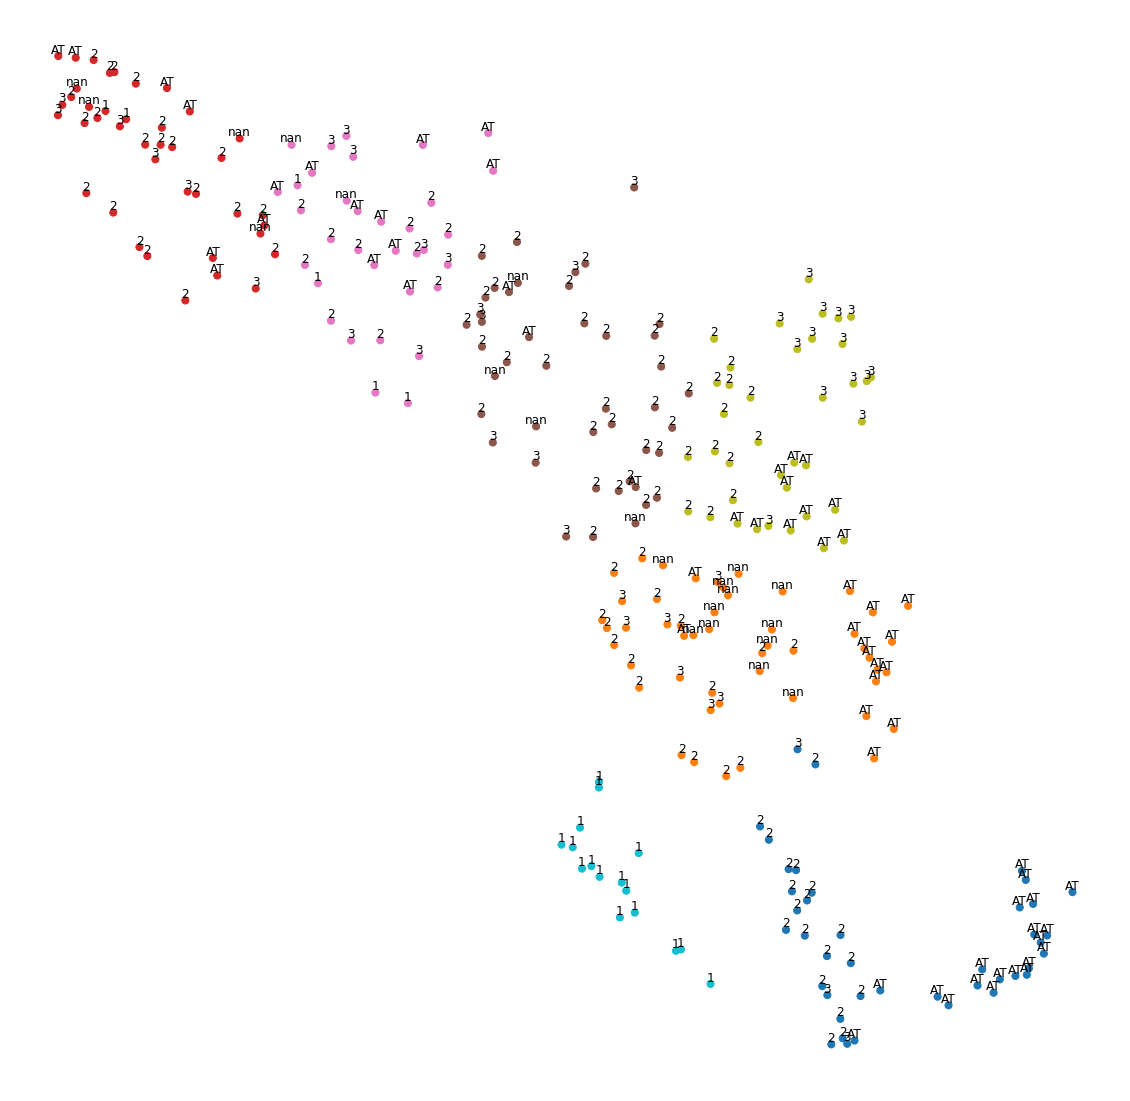

In [184]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(X, Y, c=labels_2D, s=50, cmap='tab10')
# Annotate scatter 
for i, name in enumerate(all_grades):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.axis('off')

(12.547252702713013, 21.302617025375366, 5.647686457633972, 11.596844696998597)

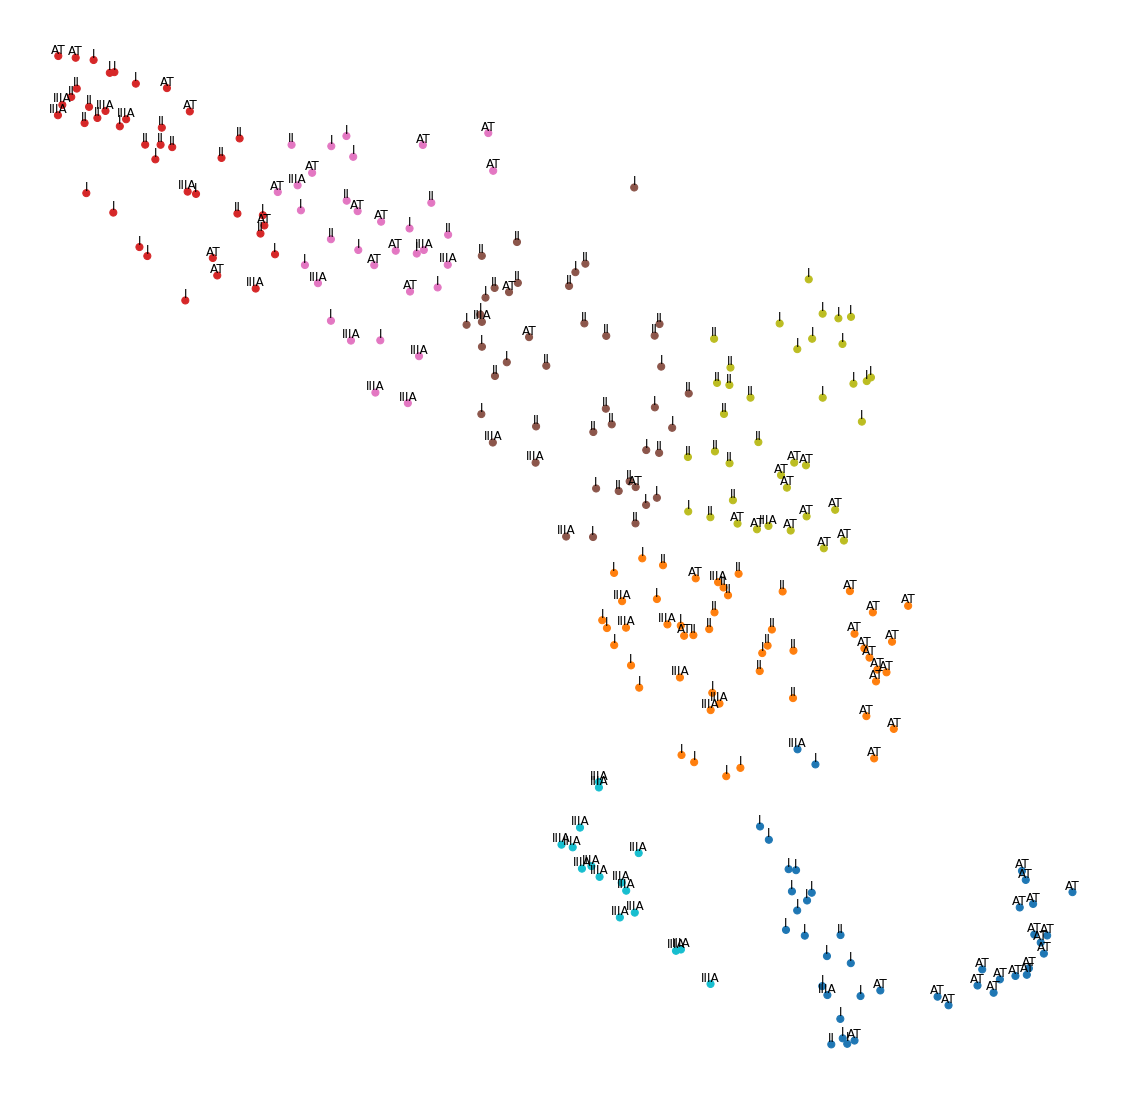

In [185]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(X, Y, c=labels_2D, s=50, cmap='tab10')
# Annotate scatter 
for i, name in enumerate(all_stages):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.axis('off')

## Per cluster stats

In [223]:
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
labels_2D = clustering.labels_

[Text(69.0, 0.5, 'Cluster'), Text(0.5, 69.0, 'Marker')]

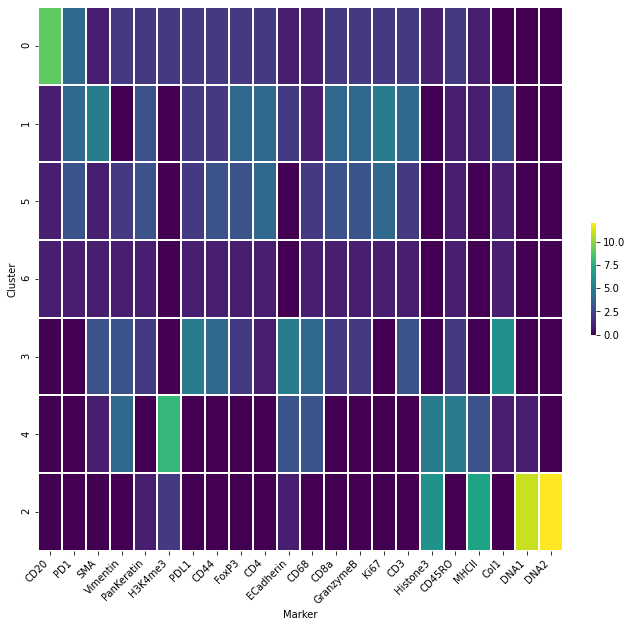

In [234]:
from collections import defaultdict, Counter

marker_count = defaultdict(Counter)
label2marker = list(zip(labels_2D, all_markers))
for label in np.unique(labels_2D):
    label_markers = list(filter(lambda x: x[0] == label, label2marker))
    label_markers = [x[1] for x in label_markers]
    marker_count[label] = Counter(label_markers)
    
df = pd.DataFrame.from_dict(marker_count, orient='index')
df.fillna(0, inplace=True)

# Plot heat map
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df, cbar_kws={
                 'fraction': 0.01}, linewidth=1, cmap="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
ax.set(xlabel='Marker', ylabel='Cluster')

[Text(69.0, 0.5, 'Cluster'), Text(0.5, 69.0, 'Grade')]

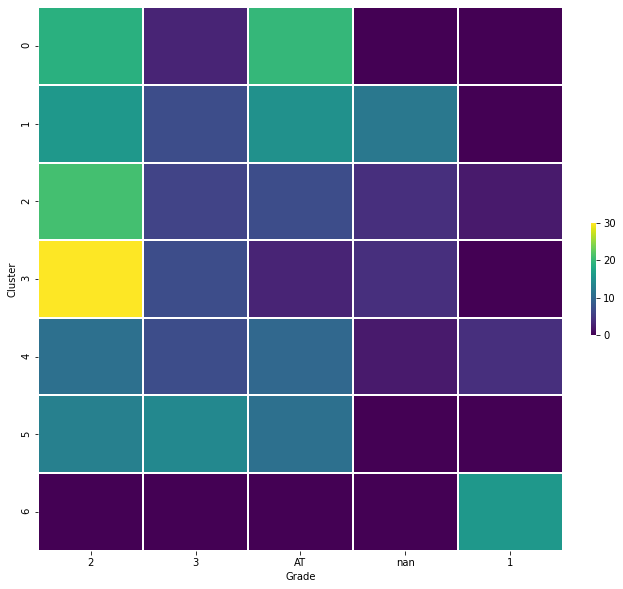

In [232]:
marker_count = defaultdict(Counter)
label2marker = list(zip(labels_2D, all_grades))
for label in np.unique(labels_2D):
    label_markers = list(filter(lambda x: x[0] == label, label2marker))
    label_markers = [x[1] for x in label_markers]
    marker_count[label] = Counter(label_markers)
    
df = pd.DataFrame.from_dict(marker_count, orient='index')
df.fillna(0, inplace=True)

# Plot heat map
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df, cbar_kws={
                 'fraction': 0.01}, linewidth=1, cmap="viridis")
ax.set(xlabel='Grade', ylabel='Cluster')

[Text(69.0, 0.5, 'Cluster'), Text(0.5, 69.0, 'Stage')]

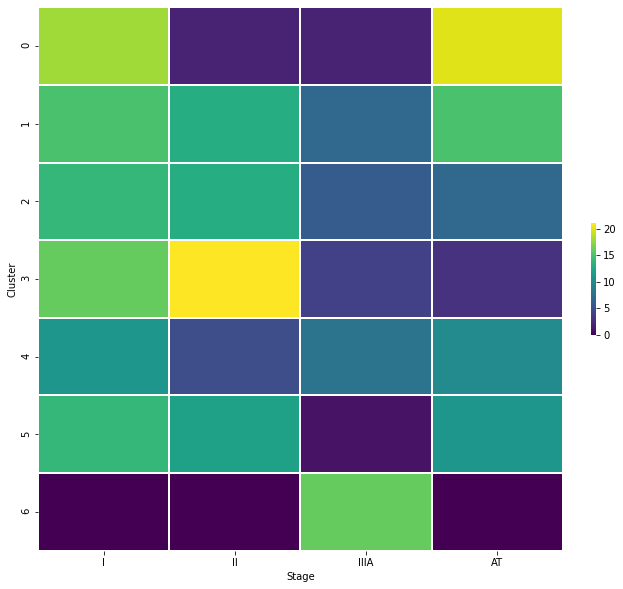

In [233]:
marker_count = defaultdict(Counter)
label2marker = list(zip(labels_2D, all_stages))
for label in np.unique(labels_2D):
    label_markers = list(filter(lambda x: x[0] == label, label2marker))
    label_markers = [x[1] for x in label_markers]
    marker_count[label] = Counter(label_markers)
    
df = pd.DataFrame.from_dict(marker_count, orient='index')
df.fillna(0, inplace=True)

# Plot heat map
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df, cbar_kws={
                 'fraction': 0.01}, linewidth=1, cmap="viridis")
ax.set(xlabel='Stage', ylabel='Cluster')

# Tissue level analysis

In [241]:
all_imgs = []
all_pos = []
all_grades = []
all_stages = []
for idx, dataset in enumerate(datasets[:-2]):
    pos = dataset_names[idx]
    grade = dataset_grades[idx]
    stage = dataset_stage[idx]
    imgs, markers = io.read_img(dataset, data_ROI)
    all_imgs.append(imgs.reshape(1,-1))
    all_pos.append([pos])
    all_grades.append([grade])
    all_stages.append([stage])

In [242]:
all_pos = list(itertools.chain(*all_pos))
all_grades = list(itertools.chain(*all_grades))
all_stages = list(itertools.chain(*all_stages))
all_imgs = np.concatenate(all_imgs, axis=0)

In [243]:
dict_pos = {}
dict_grade = {}
dict_stage = {}
all_pos_set = set(all_pos)
all_grade_set = set(all_grades)
all_stage_set = set(all_stages)

n = 0
for pos in all_pos_set:
    dict_pos[pos] = n
    n += 1
n = 0
for pos in all_grade_set:
    dict_grade[pos] = n
    n += 1
n = 0
for pos in all_stage_set:
    dict_stage[pos] = n
    n += 1
    
all_pos_int = [dict_pos[name] for name in all_pos]
all_pos_label = [pos for pos in all_pos_set]

all_grade_int = [dict_grade[name] for name in all_grades]
all_grade_label = [pos for pos in all_grade_set]

all_stage_int = [dict_stage[name] for name in all_stages]
all_stage_label = [pos for pos in all_stage_set]

Text(0, 0.5, 'explained variance')

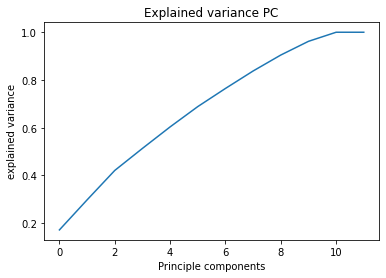

In [244]:
# Transform image to flat size for pca
imgs_flat = all_imgs.reshape((len(all_pos), -1))

# PCA transformation
pca = PCA()
pca.fit(imgs_flat)
X_pca = pca.transform(imgs_flat)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance PC")
plt.xlabel("Principle components")
plt.ylabel("explained variance")

In [260]:
embedding = umap.UMAP(random_state=2, n_neighbors=5).fit_transform(X_pca[:, :10])
X, Y = embedding[:, 0], embedding[:, 1]

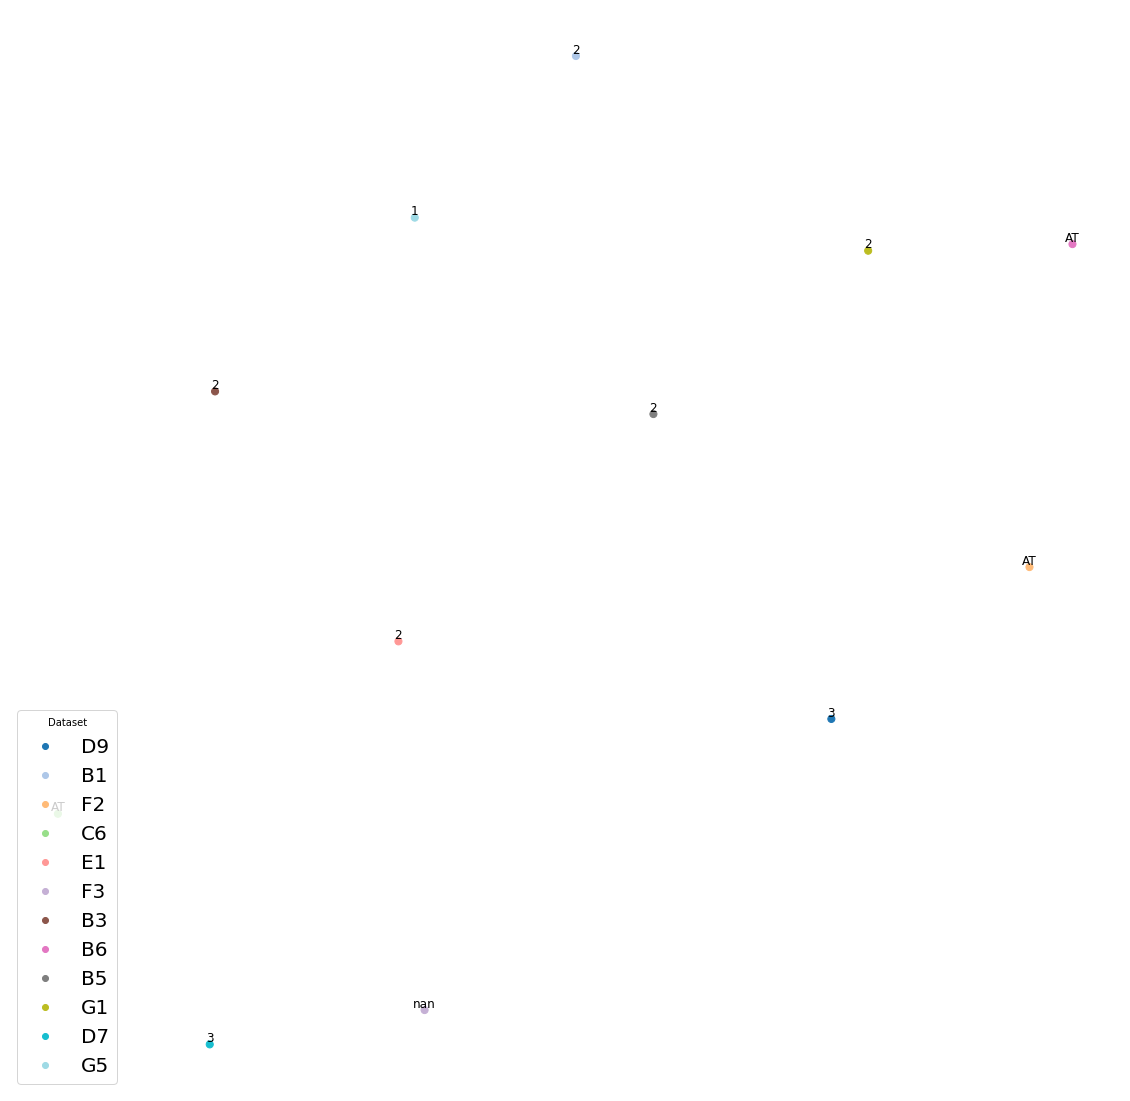

In [261]:
fig, ax = plt.subplots(figsize=(20, 20))
scatter = ax.scatter(X, Y, c=all_pos_int, cmap='tab20', s=50)
for i, name in enumerate(all_grades):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')
ax.axis('off')
ax.legend(handles=scatter.legend_elements()[0], 
          labels=all_pos_label, loc="lower left", title="Dataset", prop={'size': 20})

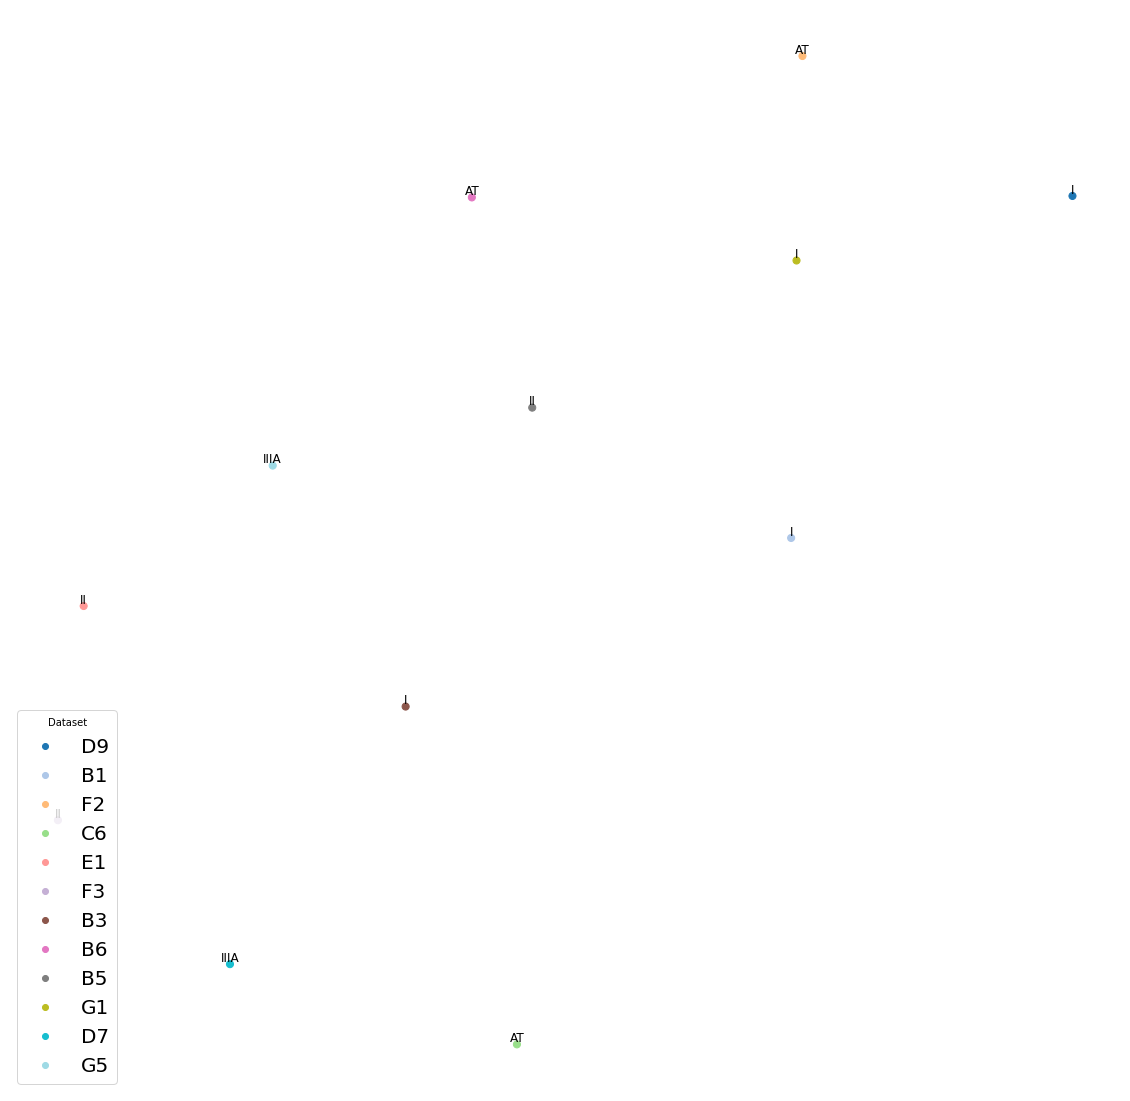

In [259]:
fig, ax = plt.subplots(figsize=(20, 20))
scatter = ax.scatter(X, Y, c=all_pos_int, cmap='tab20', s=50)
for i, name in enumerate(all_stages):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom', size=12)
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')
ax.axis('off')
ax.legend(handles=scatter.legend_elements()[0], 
          labels=all_pos_label, loc="lower left", title="Dataset", prop={'size': 20})